In [1]:
import math
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
goal_states = [1, 3]
size_of_maze = 4
episodes = 1000

discount = 0.5
alpha = 0.01
e_soft = 0.01

n = 1024

inputs = n
ouputs = 1

reward_bad = 0
reward_good = 1

threshold = -0.2

In [3]:
def hrr(length, normalized=False):
    if normalized:
        x = np.random.uniform(-np.pi,np.pi,int((length-1)/2))
        if length % 2:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.exp(-1j*x[::-1])])))
        else:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.ones(1), np.exp(-1j*x[::-1])])))
    else:
        x = np.random.normal(0.0, 1.0/np.sqrt(length), length)
    return x

In [4]:
state_hrrs = np.zeros([size_of_maze, n])
for x in range(size_of_maze):
    state_hrrs[x] = hrr(n, True)
    
color_hrrs_internal = np.zeros([len(goal_states), n])
for x in range(len(goal_states)):
    color_hrrs_internal[x] = hrr(n, True)
possible_wm = color_hrrs_internal

reward_tkn = hrr(n, True)

In [5]:
def convolve(x, y):
    return np.real(np.fft.ifft(np.fft.fft(x)*np.fft.fft(y)))
def preconvolve():
    preconvolved_matrix = np.zeros([possible_wm.size, size_of_maze, n])
    for x in range(len(possible_wm)):
        for y in range(size_of_maze):
            preconvolved_matrix[x][y] = convolve(possible_wm[x], state_hrrs[y])
    return preconvolved_matrix

In [6]:
def policy_mov(state_left, state_right, wm, rand_on):
    value_left_state_wm = nn.feedforward(preconvolved_matrix[wm][state_left])
    value_right_state_wm = nn.feedforward(preconvolved_matrix[wm][state_right])
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice([-1, 1])
    max_value = max(value_left_state_wm, value_right_state_wm)
    if(max_value == value_left_state_wm):
        return -1
    elif(max_value == value_right_state_wm):
        return 1
    
def policy_switch(state, wm, color, error):
    return (wm + 1)%2

In [7]:
class NeuralNetwork:
    def __init__(self, inputs, outputs, discount, alpha):
        self.discount = discount
        self.alpha = alpha
        self.input = inputs
        self.output = outputs
        self.weights = hrr(n, True)
        self.bias = 0
    def feedforward(self, X):
        self.output = np.dot(self.weights, X) + self.bias
        return self.output
    def backprop(self, state_prime_hrr, state_hrr, wm, y):
        if(y == reward_good):
            self.error = reward_good - self.feedforward(state_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_hrr))
        else:
            self.error = (reward_bad + self.discount * self.feedforward(state_hrr)) - self.feedforward(state_prime_hrr)
            if self.error < threshold:
                wm = policy_switch(state, wm, color, self.error)
                return wm
            self.weights = np.add(self.weights, (self.alpha * self.error * state_prime_hrr))
        return wm

In [8]:
preconvolved_matrix = preconvolve()
nn = NeuralNetwork(n, 1, discount, alpha)

In [9]:
state = random.randint(0, size_of_maze - 1)
state_prime = state
steps = 0
count = 0
wm = 0
for x in range(episodes):
        steps = 0
        count += 1
        if count <= 10:
            if count == 1:
                goal_state = goal_states[0]
            pass
        elif count > 10 and count < 20:
            if count == 11:
                goal_state = goal_states[1]
            pass
        elif count >= 20:
            count = 0
        while(steps<30):
            steps += 1
            if(state == 0):
                decision = policy_mov(size_of_maze - 1, 1, wm, 1)
                if(decision == -1):
                    state_prime = state
                    state = size_of_maze - 1
                else:
                    state_prime = state
                    state = state + decision
            elif(state == size_of_maze - 1):
                decision = policy_mov(state - 1, 0, wm, 1)
                if(decision == -1):
                    state_prime = state
                    state = state + decision
                else:
                    state_prime = state
                    state = 0
            else:
                decision = policy_mov(state - 1, state + 1, wm, 1)
                state_prime = state
                state = state + decision
            old_wm = wm
            wm = nn.backprop(preconvolved_matrix[old_wm][state_prime], preconvolved_matrix[wm][state], wm, reward_bad)
            if state == goal_state:
                nn.backprop(preconvolved_matrix[old_wm][state_prime], convolve(reward_tkn, preconvolved_matrix[wm][state]), wm, reward_good)
                break
        state = random.randint(0, size_of_maze - 1)
        state_prime = state
        print("Episode", x+1, "done")

0.006643633211939273
-0.011477846218466895
0.006516879297334969
-0.011328058352113262
0.006392184039298306
-0.011180431332645915
0.0062695154158016984
-0.011034932803641852
0.006148841896390252
-0.010891530899334558
0.006030132434666904
-0.010750194237142708
0.005913356460892683
-0.010610891910313046
0.0057984838746994866
-0.010473593480675208
0.0056854850379142625
-0.010338268971507112
0.005574330767492926
-0.010204888860509178
0.005464992328561985
-0.010073424072885492
0.0053574414275663375
-0.03280763706183107
0.05087298811783636
-0.00962434146833012
0.005092211476846683
-0.009500677254896606
0.004991402325975143
-0.009378785910541153
Episode 1 done
0.004877150433198321
0.004891965710406104
-0.009258631212205905
0.004794436951039333
-0.00914020807427222
0.0046985086756960535
-0.00902347950600868
0.004604155913049059
-0.008908420204765746
0.004511354075474662
-0.0087950052512266
0.004420078953185226
-0.008683210103572342
0.004330306708451213
-0.008573010591735472
0.004242013869911526

0.3824419761980048


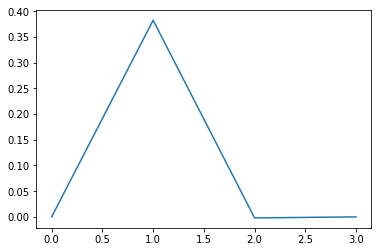

In [10]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    if z == 1:
        value[z] = nn.feedforward(convolve(reward_tkn, preconvolved_matrix[0][z]))
    else:
        value[z] = nn.feedforward(preconvolved_matrix[0][z])
plt.plot(position, value)
print(np.amax(value))

In [ ]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    if z == 3:
        value[z] = nn.feedforward(convolve(reward_tkn, preconvolved_matrix[0][z]))
    else:
        value[z] = nn.feedforward(preconvolved_matrix[0][z])
plt.plot(position, value) 
print(np.amax(value))